# Facial Keypoints Detection

### Initialization

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ipywidgets import interactive
import tensorflowjs as tfjs

%matplotlib inline
pd.options.display.width = 800

In [2]:
id_lookup_table = pd.read_csv('./IdLookupTable.csv')

train = pd.read_csv('./training.csv')
print('Initial Training', train.shape)

test = pd.read_csv('./test.csv', index_col=0)
print('Initial Test', test.shape)

Initial Training (7049, 31)
Initial Test (1783, 1)


### Exploratory Data Analysis (EDA)

In [3]:
# View data

train.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


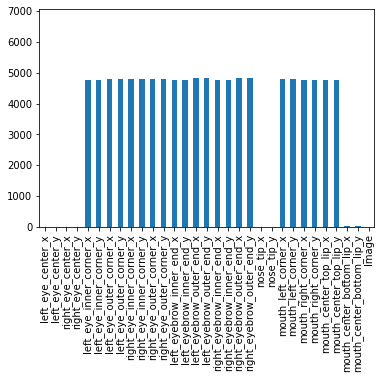

In [4]:
# Missing values

train.isnull().sum().plot(kind='bar')
plt.ylim(0, len(train))
plt.show()

# different options to fix na values
# inplace saves space but I want the flexibility to switch later without reloading the original dataset

# train_no_na = train.dropna(axis=0).copy().reset_index(drop=True)
# train_no_na = train.fillna(value=0).copy()
train_no_na = train.fillna(method='ffill').copy()


In [5]:
# Modify image data in-place

def format_string_into_list(target, from_col):
	target['image_data'] = target[from_col].map(lambda x: np.array([int(y) for y in x.split(' ')]))
	assert len(target['image_data'].map(len).unique()) == 1, f'Missing or uneven lengths in image data: {target.image_data.map(len)}' 
	assert min(target['image_data'].map(min)) >= 0, 'Negative values in image data'
	assert max(target['image_data'].map(max)) < 256, 'Unexpectedly large values in image data'

In [6]:
format_string_into_list(train_no_na, 'Image')

In [7]:
# Show face

def plot_face(index):
	plt.imshow(train_no_na.at[index, 'image_data'].reshape(96, 96), cmap='gray')
	keypoints = train_no_na.iloc[index, :~1].to_numpy()
	plt.scatter(keypoints[0::2], keypoints[1::2])
	plt.xticks([])
	plt.yticks([])
	plt.show()

interactive(plot_face, index=train_no_na.index)

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### Model Building

In [8]:
model = tf.keras.Sequential([
	tf.keras.layers.Flatten(input_shape=(96, 96, 1)),
		tf.keras.layers.Dense(128, activation="relu"),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Dense(64, activation="relu"),
		tf.keras.layers.Dense(30)
])

In [9]:
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [10]:
x = np.concatenate(train_no_na.image_data.to_numpy()).reshape(-1, 96, 96)
y = np.concatenate(train_no_na.iloc[:,:~1].to_numpy()).reshape(-1, len(train_no_na.columns) - 2)
print(x.shape, y.shape)
model.fit(x, y, epochs=5)


(7049, 96, 96) (7049, 30)
Epoch 1/5
221/221 [==============================] - 4s 18ms/step - loss: 4793.8970 - acc: 0.3100
Epoch 2/5
221/221 [==============================] - 3s 13ms/step - loss: 386.4444 - acc: 0.5731
Epoch 3/5
221/221 [==============================] - 3s 13ms/step - loss: 359.8048 - acc: 0.5632
Epoch 4/5
221/221 [==============================] - 3s 13ms/step - loss: 354.7314 - acc: 0.5621
Epoch 5/5
221/221 [==============================] - 3s 13ms/step - loss: 362.7036 - acc: 0.5595


### Analysis of Predictions

In [11]:
format_string_into_list(test, 'Image')

In [12]:
x = np.concatenate(test.image_data.to_numpy()).reshape(-1, 96, 96)
y = model.predict(x)

In [13]:
# Show face

def plot_face2(index):
	plt.imshow(test.at[index, 'image_data'].reshape(96, 96), cmap='gray')
	predicted_kp = y[index]
	plt.scatter(predicted_kp[0::2], predicted_kp[1::2], color='red')
	plt.xticks([])
	plt.yticks([])
	plt.show()

interactive(plot_face2, index=test.index)

interactive(children=(Dropdown(description='index', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15…

### Export model into TFJS

In [15]:
tfjs.converters.save_keras_model(model, 'tfjs_model', weight_shard_size_bytes=999999999)